# Credit Card Defaults

## Data Preprocessing


In [180]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from scipy.stats import randint, uniform
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import utils

In [181]:
# Load the data
df = pd.read_csv('../data/UCI_Credit_Card.csv')
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [182]:
# Check for missing values
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [183]:
# Check for duplicates
df.duplicated().sum()

0

## Exploratory Data Analysis

In [184]:
# Describe the data
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


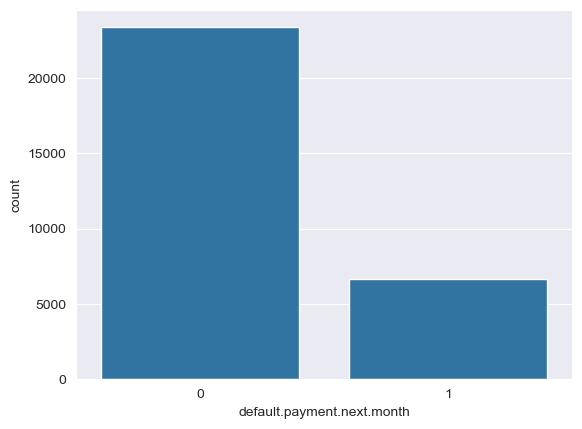

In [185]:
 # plot the distribution of the target variable
sns.countplot(x='default.payment.next.month', data=df)
plt.show()

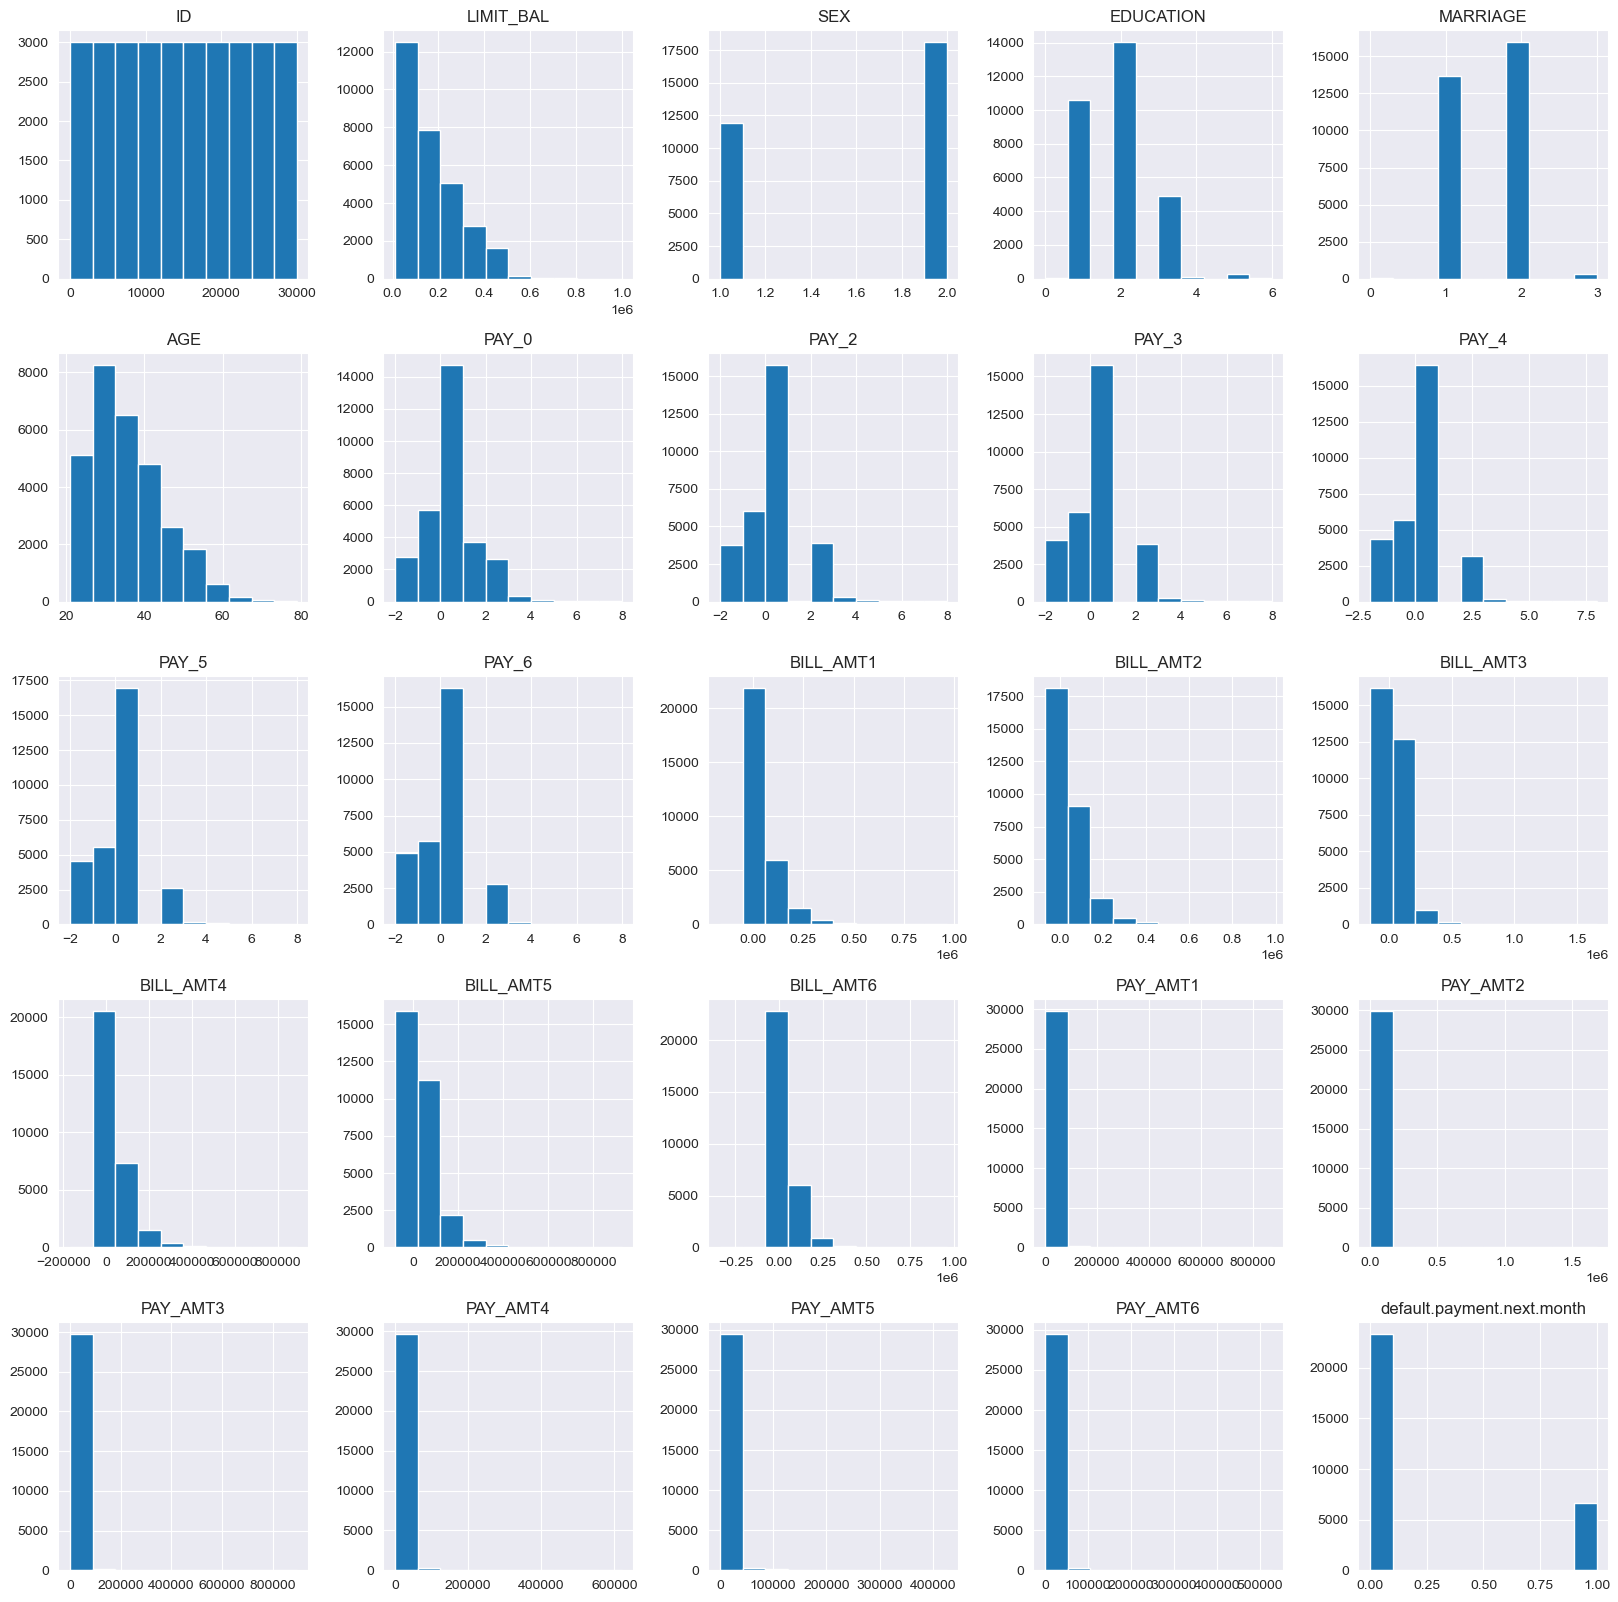

In [186]:
# plot the distribution of the features
df.hist(figsize=(20, 20))
plt.show()

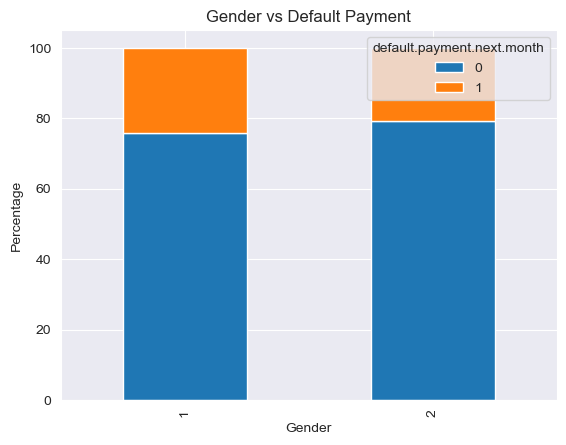

In [187]:
# mapping gender vs default payment
ct_percentage = pd.crosstab(df['SEX'], df['default.payment.next.month'], normalize='index') * 100
ct_percentage.plot(kind='bar', stacked=True)
plt.title('Gender vs Default Payment')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.show()

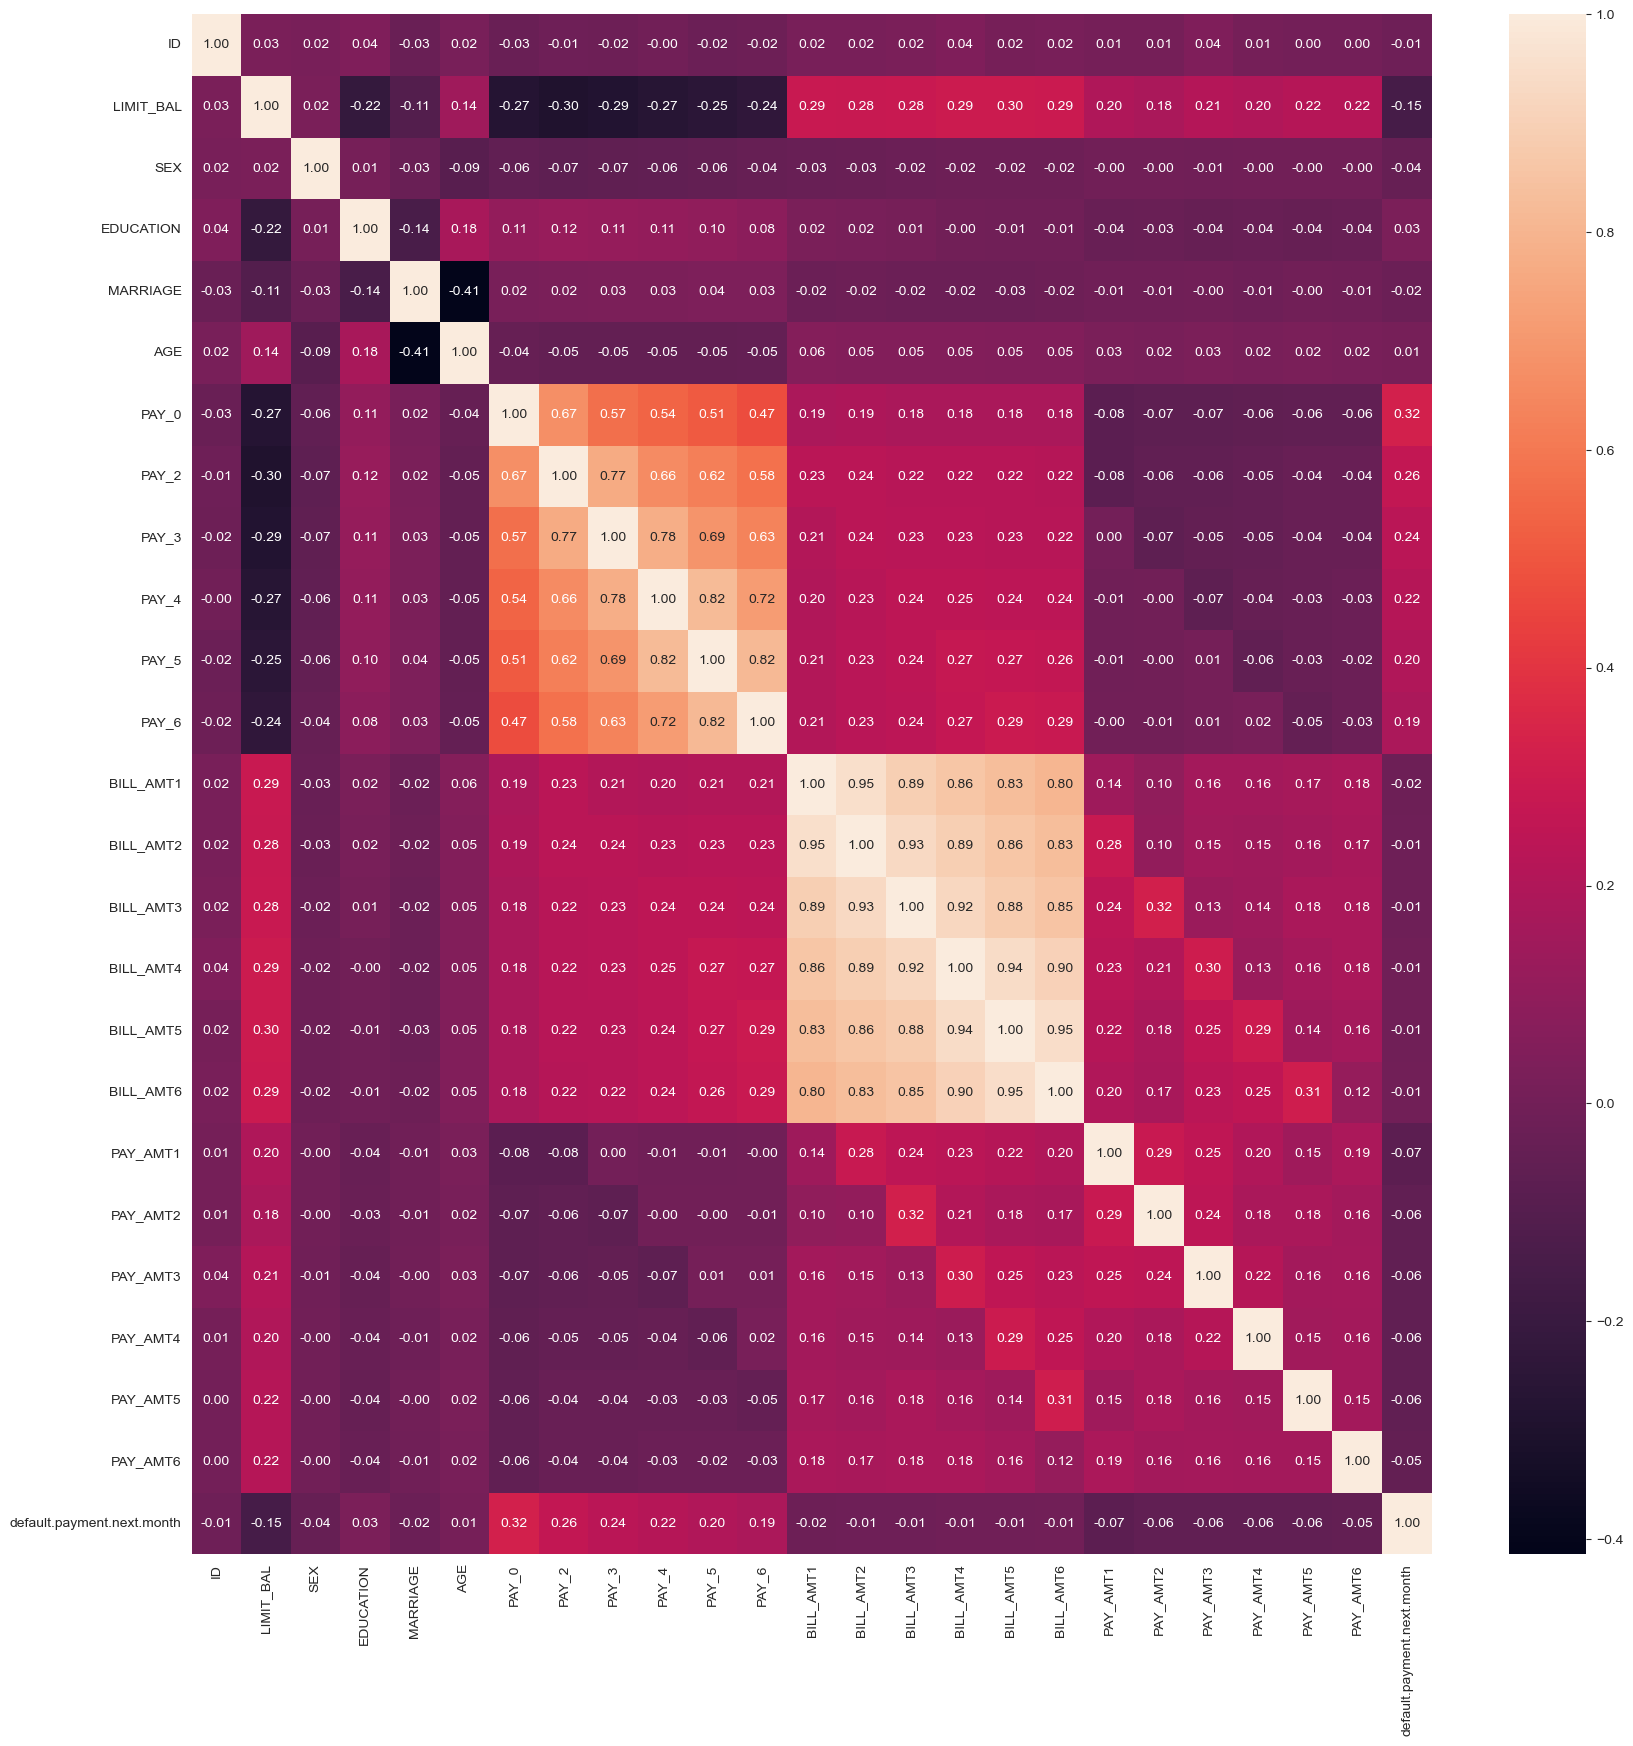

In [188]:
# plot the correlation matrix
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

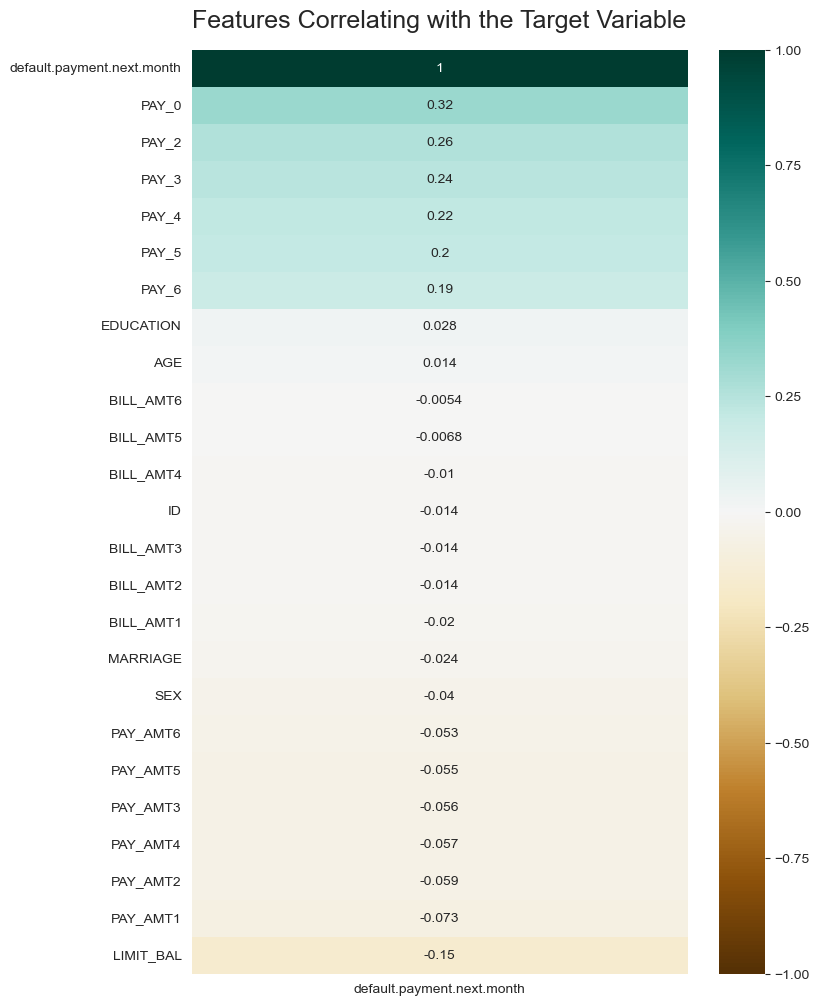

In [189]:
# plot the correlation between features and the target variable without using utils
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['default.payment.next.month']].sort_values(by='default.payment.next.month', ascending=False),
                        vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with the Target Variable', fontdict={'fontsize': 18}, pad=16)
plt.show()

In [190]:
# mapping class variables

GenderMap = {1: 'male', 2: 'female'}
EducationMap = {1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others', 5: 'unknown', 6: 'unknown'}
MarriageMap = {1: 'married', 2: 'single', 3: 'others', 0: 'others'}

df['SEX'] = df['SEX'].map(GenderMap)
df['EDUCATION'] = df['EDUCATION'].map(EducationMap)
df['MARRIAGE'] = df['MARRIAGE'].map(MarriageMap)
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,female,university,married,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,female,university,single,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,female,university,single,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,female,university,married,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,male,university,married,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,male,high school,married,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,male,high school,single,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,male,university,single,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,male,high school,married,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [191]:
# Convert negative values in the PAY columns to none
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in pay_cols:
    df[col] = df[col].apply(lambda x: None if x < 0 else x)

bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

for col in bill_cols:
    df[col] = df[col].apply(lambda x: None if x < 0 else x)

df.describe()

,ID,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,21555.000000,20168.000000,19977.000000,19965.000000,19915.000000,19365.000000,29410.000000,...,29325.000000,29345.000000,29312.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,35.485500,0.496544,0.476051,0.456625,0.388830,0.333668,0.350994,52274.099184,...,44296.319113,41247.666144,39856.306734,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,9.217904,0.857762,0.939073,0.932189,0.905484,0.859398,0.865617,73980.385876,...,64690.404377,61138.023655,59835.937366,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4205.250000,...,2915.000000,2267.000000,1650.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23792.000000,...,19583.000000,18705.000000,17908.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,41.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68612.750000,...,56271.000000,51074.000000,50000.000000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [192]:
df.dropna(inplace=True)

## Feature Engineering

### Dummify Categorical Variables

In [196]:
# Split the data into features and target
X = df.drop(columns=['ID', 'default.payment.next.month'], axis=1)
y = df['default.payment.next.month']

In [197]:
# dummify the categorical variables
categorical_variables = [col for col in df.columns if df[col].dtype == 'object']
df_categorical = X[categorical_variables]
df_numeric = X.drop(columns=categorical_variables, axis=1)

df_dummies = pd.get_dummies(df_categorical, drop_first=True)
X = pd.concat([df_numeric, df_dummies], axis=1)
X

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_male,EDUCATION_high school,EDUCATION_others,EDUCATION_university,EDUCATION_unknown,MARRIAGE_others,MARRIAGE_single
2,90000.0,34,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,...,1000.0,1000.0,5000.0,False,False,False,True,False,False,True
3,50000.0,37,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,48233.0,...,1100.0,1069.0,1000.0,False,False,False,True,False,False,False
5,50000.0,37,0.0,0.0,0.0,0.0,0.0,0.0,64400.0,57069.0,...,1000.0,1000.0,800.0,True,False,False,False,False,False,True
6,500000.0,29,0.0,0.0,0.0,0.0,0.0,0.0,367965.0,412023.0,...,20239.0,13750.0,13770.0,True,False,False,False,False,False,True
8,140000.0,28,0.0,0.0,2.0,0.0,0.0,0.0,11285.0,14096.0,...,1000.0,1000.0,1000.0,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29990,140000.0,41,0.0,0.0,0.0,0.0,0.0,0.0,138325.0,137142.0,...,1505.0,2000.0,2000.0,True,False,False,True,False,False,False
29991,210000.0,34,3.0,2.0,2.0,2.0,2.0,2.0,2500.0,2500.0,...,0.0,0.0,0.0,True,False,False,True,False,False,False
29994,80000.0,34,2.0,2.0,2.0,2.0,2.0,2.0,72557.0,77708.0,...,7000.0,0.0,4000.0,True,False,False,True,False,False,True
29995,220000.0,39,0.0,0.0,0.0,0.0,0.0,0.0,188948.0,192815.0,...,3047.0,5000.0,1000.0,True,True,False,False,False,False,False


In [198]:
# convert the one hot encoded columns to integers
X = X.astype(float)
X

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_male,EDUCATION_high school,EDUCATION_others,EDUCATION_university,EDUCATION_unknown,MARRIAGE_others,MARRIAGE_single
2,90000.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,...,1000.0,1000.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,50000.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,48233.0,...,1100.0,1069.0,1000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,50000.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,64400.0,57069.0,...,1000.0,1000.0,800.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,500000.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,367965.0,412023.0,...,20239.0,13750.0,13770.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8,140000.0,28.0,0.0,0.0,2.0,0.0,0.0,0.0,11285.0,14096.0,...,1000.0,1000.0,1000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29990,140000.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,138325.0,137142.0,...,1505.0,2000.0,2000.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
29991,210000.0,34.0,3.0,2.0,2.0,2.0,2.0,2.0,2500.0,2500.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
29994,80000.0,34.0,2.0,2.0,2.0,2.0,2.0,2.0,72557.0,77708.0,...,7000.0,0.0,4000.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
29995,220000.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,188948.0,192815.0,...,3047.0,5000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


### Remove Highly Correlated Features

In [199]:
# remove columns with high multicollinearity
X_vif = utils.calculate_vif(X, threshold=5)
X_vif

Removed variables with high VIF:
BILL_AMT2: 86.30
BILL_AMT5: 59.36
BILL_AMT3: 49.75
BILL_AMT4: 28.52
BILL_AMT1: 8.35
AGE: 6.92


,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_male,EDUCATION_high school,EDUCATION_others,EDUCATION_university,EDUCATION_unknown,MARRIAGE_others,MARRIAGE_single
2,90000.0,0.0,0.0,0.0,0.0,0.0,0.0,15549.0,1518.0,1500.0,...,1000.0,1000.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,29547.0,2000.0,2019.0,...,1100.0,1069.0,1000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,20024.0,2500.0,1815.0,...,1000.0,1000.0,800.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,500000.0,0.0,0.0,0.0,0.0,0.0,0.0,473944.0,55000.0,40000.0,...,20239.0,13750.0,13770.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8,140000.0,0.0,0.0,2.0,0.0,0.0,0.0,3719.0,3329.0,0.0,...,1000.0,1000.0,1000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29990,140000.0,0.0,0.0,0.0,0.0,0.0,0.0,46121.0,6000.0,7000.0,...,1505.0,2000.0,2000.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
29991,210000.0,3.0,2.0,2.0,2.0,2.0,2.0,2500.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
29994,80000.0,2.0,2.0,2.0,2.0,2.0,2.0,81158.0,7000.0,3500.0,...,7000.0,0.0,4000.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
29995,220000.0,0.0,0.0,0.0,0.0,0.0,0.0,15980.0,8500.0,20000.0,...,3047.0,5000.0,1000.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


### Split the Data

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.3, random_state=42, stratify=y)

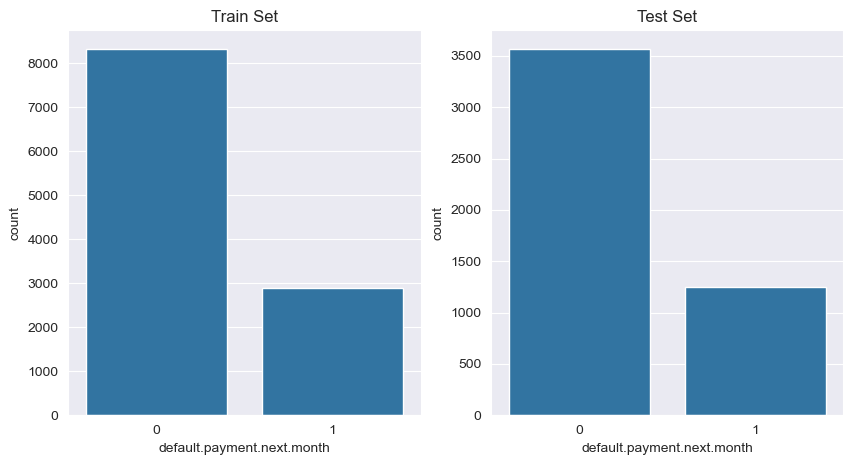

In [201]:
# plot the distribution of the target variable in the train and test sets
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title('Train Set')
sns.countplot(x=y_test, ax=ax[1])
ax[1].set_title('Test Set')
plt.show()

### Standardization (for Logistic Regression)

In [202]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled array back to DataFrame with original column names
X_train_scaled_res_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

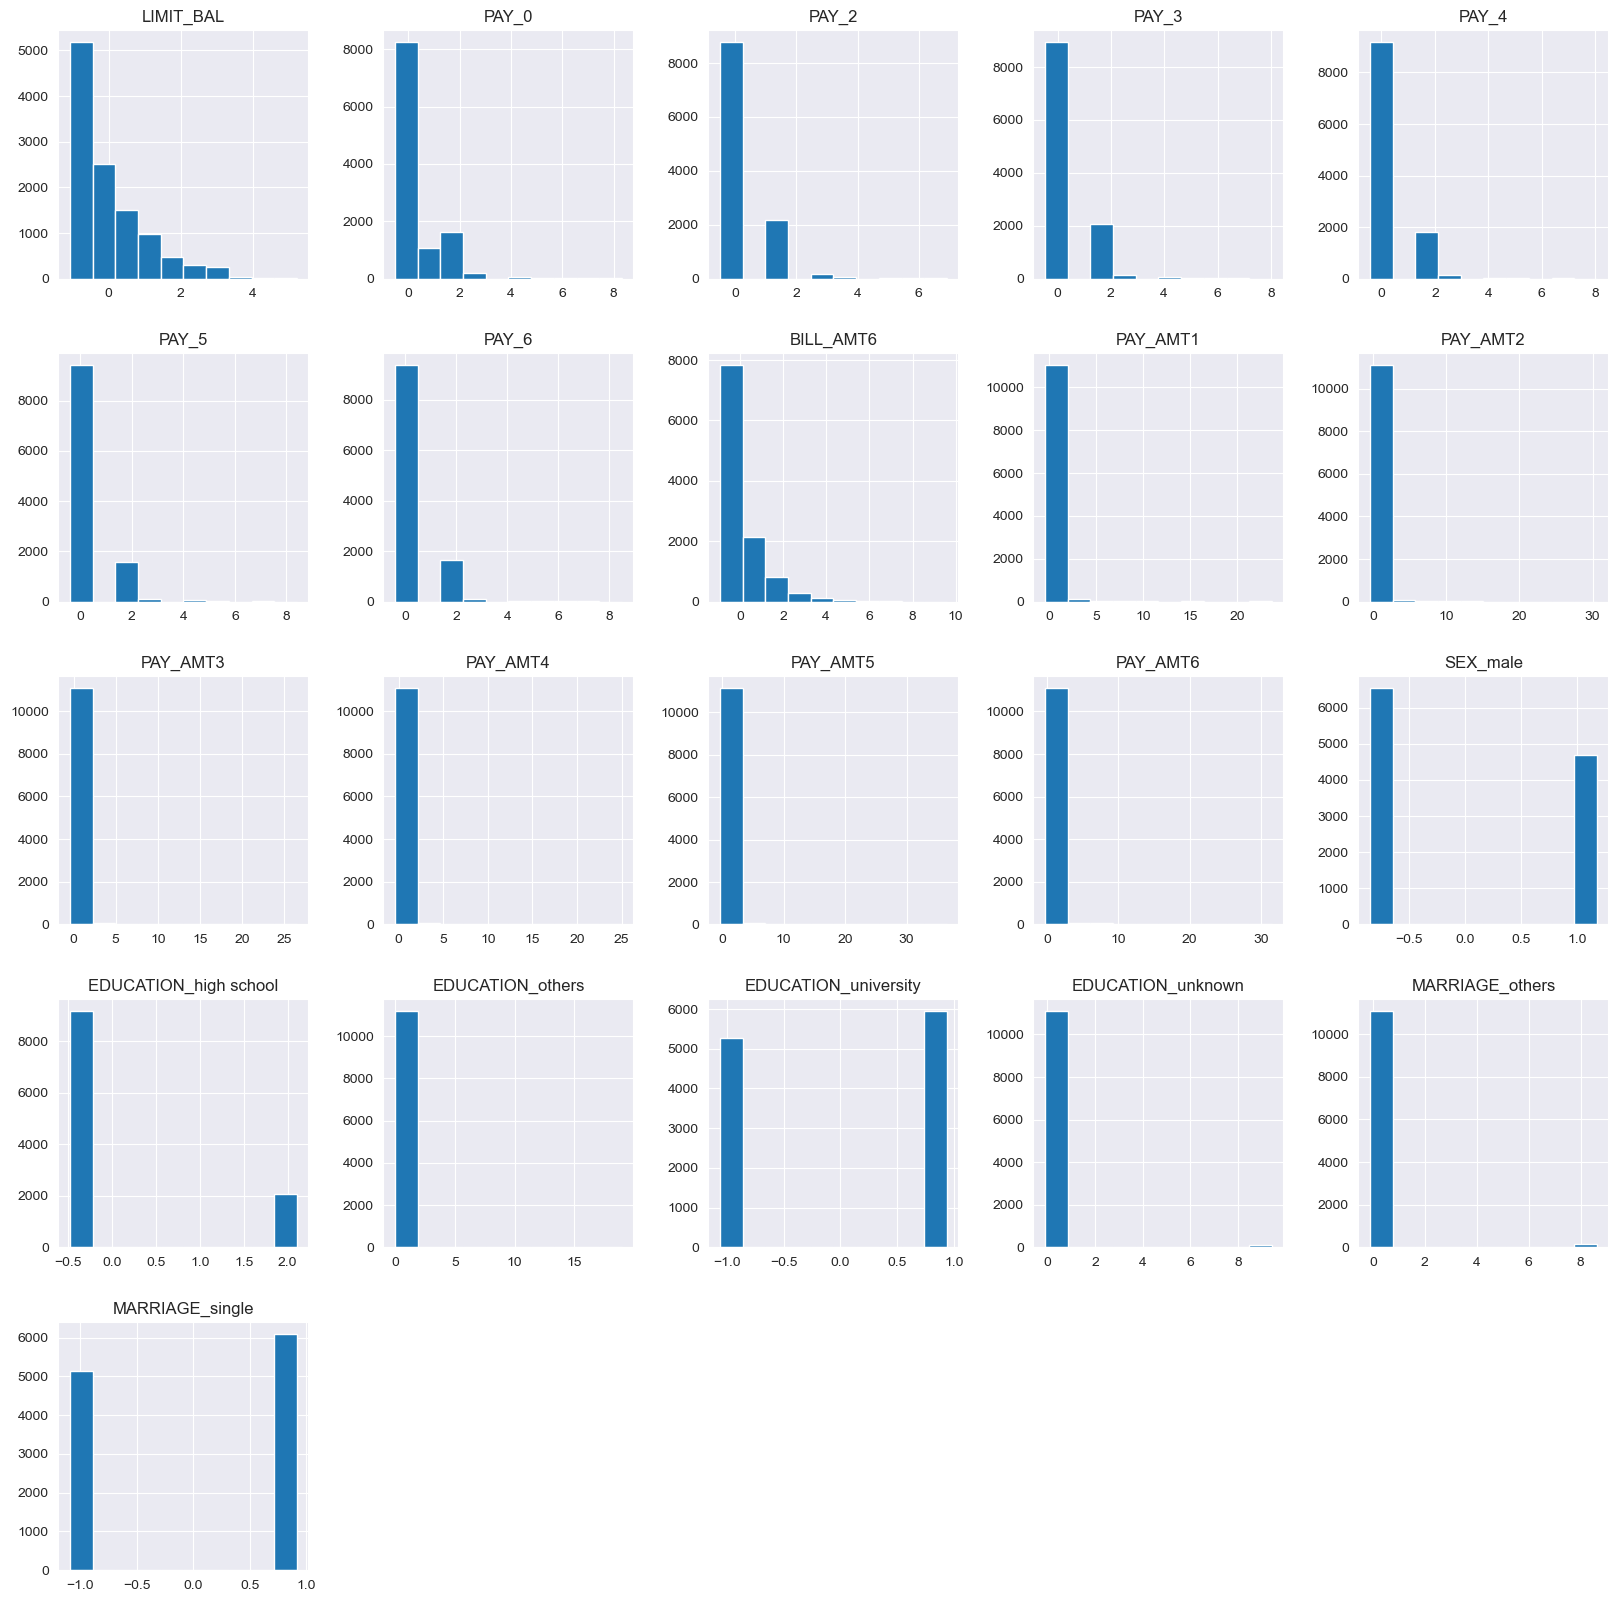

In [203]:
# Plot the distribution of the scaled features
pd.DataFrame(X_train_scaled_res_df).hist(figsize=(20, 20))
plt.show()

## Model Selection

### Scoring and Cross-Validation

In [204]:
# Define a custom scorer
scorer = make_scorer(f1_score)

We will use recall as the scoring metric because we want to minimize the number of false negatives. In the context of credit card defaults, a false negative would be predicting that a customer will not default when they actually do default. This would result in a financial loss for the credit card company.

In [205]:
# Create a stratified k-fold object to ensure class balance across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Logistic Regression

In [206]:
# use logit regression as the model

# Reset the index of y_train to match X_train_scaled_const
y_train_scaled = y_train.reset_index(drop=True)

# Add a constant for the intercept
X_train_scaled_const = sm.add_constant(X_train_scaled_res_df)

logit_model = sm.Logit(y_train_scaled, X_train_scaled_const).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.445177
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     default.payment.next.month   No. Observations:                11236
Model:                                  Logit   Df Residuals:                    11214
Method:                                   MLE   Df Model:                           21
Date:                        Fri, 04 Oct 2024   Pseudo R-squ.:                  0.2209
Time:                                14:08:06   Log-Likelihood:                -5002.0
converged:                               True   LL-Null:                       -6420.6
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 

In [207]:
# evaluate the model
X_test_scaled_const = sm.add_constant(X_test_scaled_df)
y_pred_prob = logit_model.predict(X_test_scaled_const)  # Predicted probabilities for test data
y_pred_logit = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

#### Hyperparameter Tuning

In [268]:
# create a sklearn model
lr_model = LogisticRegression(random_state=42)

In [269]:
# Define the parameter grid for GridSearchCV
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for stopping criteria
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Optimization algorithms
    'max_iter': [100, 200, 500]  # Maximum number of iterations
}

##### GridSearchCV

In [270]:
# Create a GridSearchCV object
logit_grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

logit_grid_search.fit(X_train_scaled_const, y_train_scaled)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/garrinshieh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/garrinshieh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/garrinshieh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/garrinshieh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/garrinshieh/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/garrinshieh/anaconda3/lib/py

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200, 500],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear', 'saga'],
                         'tol': [0.0001, 0.001, 0.01]},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

##### Best Parameters and Score

In [271]:
# Print the best parameters and score
print("Best Parameters: ", logit_grid_search.best_params_)
print("Best Score: ", logit_grid_search.best_score_)

Best Parameters:  {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.01}
Best Score:  0.5840523410031371


In [272]:
# evaluate the model with the best hyperparameters
y_pred_lr_hyper = logit_grid_search.predict(X_test_scaled_const)

### Random Forest

In [213]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [214]:
# evaluate the model
y_pred_rf = rf_model.predict(X_test)

#### Hyperparameter Tuning

In [215]:
# Define the parameter grid for GridSearchCV
param_distributions_rf = {
    'n_estimators': randint(100, 1000),  # Number of trees (100 to 1000)
    'max_depth': randint(1, 10),  # Depth of trees (1 to 10)
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required in a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
    'bootstrap': [True, False],  # Whether to use bootstrapping
}

##### RandomizedSearchCV

In [216]:
# Create a GridSearchCV object
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions_rf,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14fd82610>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3052994d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x304cac110>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16a945210>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

##### Best Parameters and Score

In [217]:
# Print the best parameters and score
print("Best Parameters: ", rf_random_search.best_params_)
print("Best Score: ", rf_random_search.best_score_)

Best Parameters:  {'bootstrap': False, 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 198}
Best Score:  0.6259419042107836


In [218]:
# evaluate the model with the best hyperparameters
y_pred_rf_hyper = rf_random_search.predict(X_test)

### AdaBoost

In [219]:
# use adaboost as the model
base_estimator = DecisionTreeClassifier(random_state=42)

ada_model = AdaBoostClassifier(estimator=base_estimator, algorithm="SAMME", random_state=42)
ada_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(random_state=42),
                   random_state=42)

In [220]:
# evaluate the model
y_pred_ada = ada_model.predict(X_test)

#### Hyperparameter Tuning

In [221]:
# Define the parameter grid for GridSearchCV
param_distributions_ada = {
    'n_estimators': randint(50, 500),  # Number of boosting stages
    'learning_rate': uniform(0.01, 1),  # Shrinkage step size
    'estimator__max_depth': randint(1, 10),  # Tuning max depth of base decision tree
    'estimator__min_samples_split': randint(2, 20),  # Min samples to split in the base tree
    'estimator__min_samples_leaf': randint(1, 10),  # Min samples for leaves
}

##### RandomizedSearchCV

In [222]:
# Create a GridSearchCV object
ada_grid_search = RandomizedSearchCV(
    estimator=ada_model,
    param_distributions=param_distributions_ada,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

ada_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=AdaBoostClassifier(algorithm='SAMME',
                                                estimator=DecisionTreeClassifier(random_state=42),
                                                random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'estimator__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16a8f97d0>,
                                        'estimator__min_sa...
                                        'estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30b1e3bd0>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3059f3a90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x304cacb50>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

##### Best Parameters and Score

In [223]:
# Print the best parameters and score
print("Best Parameters: ", ada_grid_search.best_params_)
print("Best Score: ", ada_grid_search.best_score_)

Best Parameters:  {'estimator__max_depth': 1, 'estimator__min_samples_leaf': 8, 'estimator__min_samples_split': 6, 'learning_rate': 0.6939637693981411, 'n_estimators': 65}
Best Score:  0.6124770306257178


In [224]:
# evaluate the model with the best hyperparameters
y_pred_ada_hyper = ada_grid_search.predict(X_test)

### XGBoost

In [225]:
# use xgboost as the model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [226]:
# evaluate the model
y_pred_xgb = xgb_model.predict(X_test)

#### Hyperparameter Tuning

In [227]:
# Define the parameter distribution for GridSearchCV
param_distributions_xgb = {
    'n_estimators': randint(100, 1000),  # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),  # Step size shrinkage
    'max_depth': randint(3, 15),  # Maximum depth of a tree
    'min_child_weight': randint(1, 10),  # Minimum sum of instance weight (hessian) needed in a child
    'gamma': uniform(0, 0.5),  # Minimum loss reduction to make a split
    'subsample': uniform(0.1, 0.9),  # Subsample ratio of the training data
    'colsample_bytree': uniform(0.1, 0.9),  # Subsample ratio of columns when constructing each tree
    'scale_pos_weight': randint(1, 10),  # Controls the balance of positive and negative classes
}

##### RandomizedSearchCV

In [228]:
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_random_search.fit(X_train, y_train, verbose=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14f113710>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x30b77f310>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x304d65dd0>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

##### Best Parameters and Score

In [229]:
# Print the best parameters and score
print("Best Parameters: ", xgb_random_search.best_params_)
print("Best Score: ", xgb_random_search.best_score_)

Best Parameters:  {'colsample_bytree': 0.3507313051287628, 'gamma': 0.08850524213837341, 'learning_rate': 0.036610760127116684, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 332, 'scale_pos_weight': 2, 'subsample': 0.21587355846967954}
Best Score:  0.6299395046600498


In [230]:
# evaluate the model with the best hyperparameters
y_pred_xgb_hyper = xgb_random_search.predict(X_test)

## Model Evaluation

### Logistic Regression

#### Coefficients

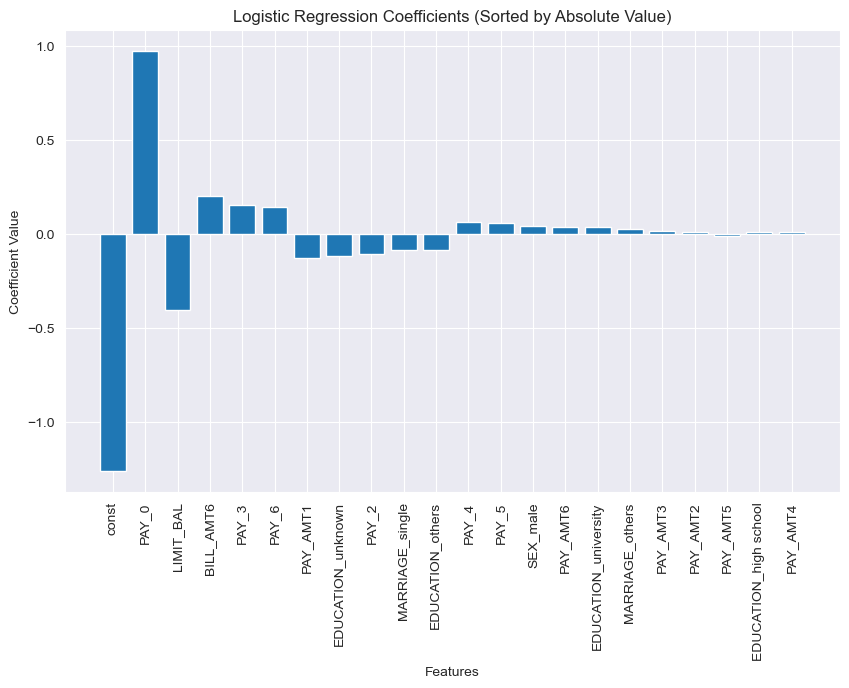

In [273]:
# Extract the coefficients
coefficients = logit_model.params

# Sort the coefficients by their absolute values
sorted_coefficients = coefficients.reindex(coefficients.abs().sort_values(ascending=False).index)

# Extract the feature names
sorted_features = sorted_coefficients.index.tolist()

# Plot the sorted feature names
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_coefficients)
plt.title('Logistic Regression Coefficients (Sorted by Absolute Value)')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

#### Accuracy

In [274]:
accuracy = accuracy_score(y_test, y_pred_logit)
print("Accuracy:", accuracy)

Accuracy: 0.8100083056478405


#### Confusion Matrix

In [275]:
conf_matrix = confusion_matrix(y_test, y_pred_logit)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3294  277]
 [ 638  607]]


#### Classification Report

In [276]:
# use classification report
class_report = classification_report(y_test, y_pred_logit)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3571
           1       0.69      0.49      0.57      1245

    accuracy                           0.81      4816
   macro avg       0.76      0.70      0.72      4816
weighted avg       0.80      0.81      0.80      4816



This model is doing a good job predicting when people are not going to default on their credit cards, but it is doing a poor job of predicting when people are going to default on their credit cards. The model has a high precision and recall for the negative class, but a low precision and recall for the positive class.

#### ROC Curve

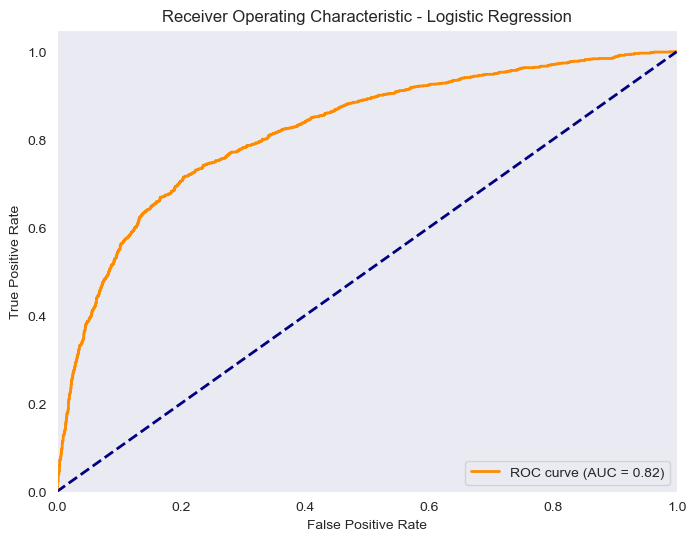

In [277]:
# plot roc curve
utils.plot_roc_curve(y_test, y_pred_prob, model_name='Logistic Regression')

#### with Hyperparameter Tuning

##### Accuracy

In [278]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr_hyper)
print("Accuracy:", accuracy)

Accuracy: 0.8108388704318937


##### Confusion Matrix

In [279]:
conf_matrix = confusion_matrix(y_test, y_pred_lr_hyper)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3291  280]
 [ 631  614]]


##### Classification Report

In [280]:
# use classification report
class_report = classification_report(y_test, y_pred_lr_hyper)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3571
           1       0.69      0.49      0.57      1245

    accuracy                           0.81      4816
   macro avg       0.76      0.71      0.73      4816
weighted avg       0.80      0.81      0.80      4816



##### ROC Curve

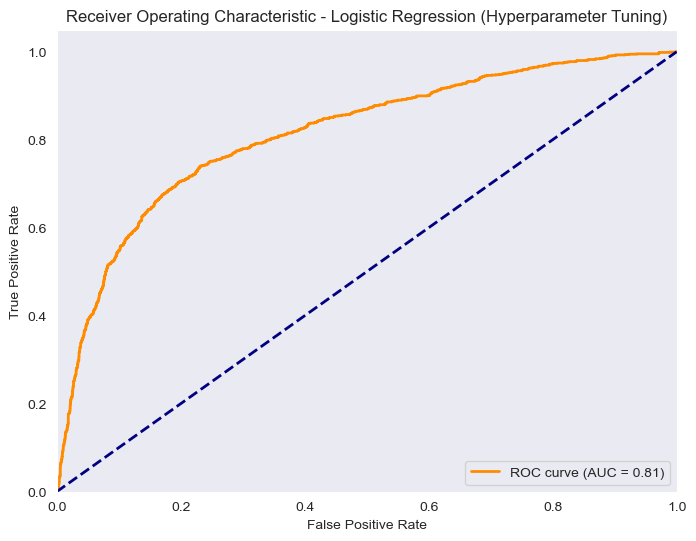

In [281]:
# plot roc curve
y_pred_prob = logit_grid_search.predict_proba(X_test_scaled_const)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='Logistic Regression (Hyperparameter Tuning)')

### Random Forest

#### Feature Importances

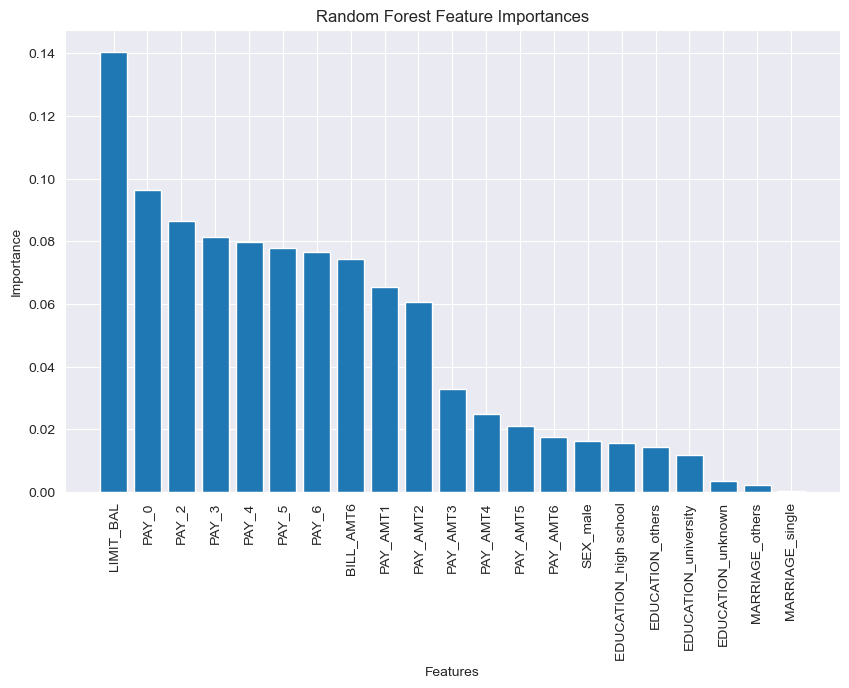

In [240]:
# plot the feature importances

# Extract the feature importances
feature_importances = rf_model.feature_importances_

# Sort the feature importances
sorted_indices = feature_importances.argsort()[::-1]
feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importances)
plt.title('Random Forest Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

#### Accuracy

In [241]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.8037790697674418


#### Confusion Matrix

In [242]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3222  349]
 [ 596  649]]


#### Classification Report

In [243]:
# use classification report
class_report = classification_report(y_test, y_pred_rf)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3571
           1       0.65      0.52      0.58      1245

    accuracy                           0.80      4816
   macro avg       0.75      0.71      0.73      4816
weighted avg       0.79      0.80      0.80      4816



#### ROC Curve

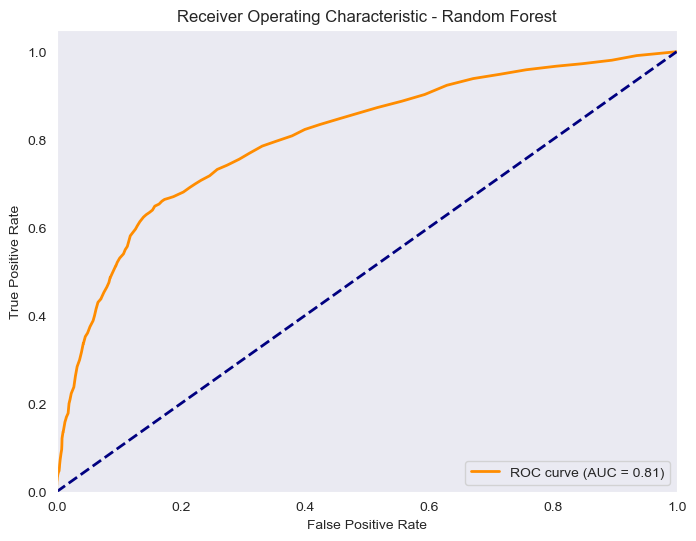

In [244]:
# plot roc curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='Random Forest')

#### with Hyperparameter Tuning

##### Accuracy

In [245]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf_hyper)
print("Accuracy:", accuracy)

Accuracy: 0.7948504983388704


##### Confusion Matrix

In [246]:
conf_matrix = confusion_matrix(y_test, y_pred_rf_hyper)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3048  523]
 [ 465  780]]


##### Classification Report

In [247]:
# use classification report
class_report = classification_report(y_test, y_pred_rf_hyper)
print(class_report)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3571
           1       0.60      0.63      0.61      1245

    accuracy                           0.79      4816
   macro avg       0.73      0.74      0.74      4816
weighted avg       0.80      0.79      0.80      4816



##### ROC Curve

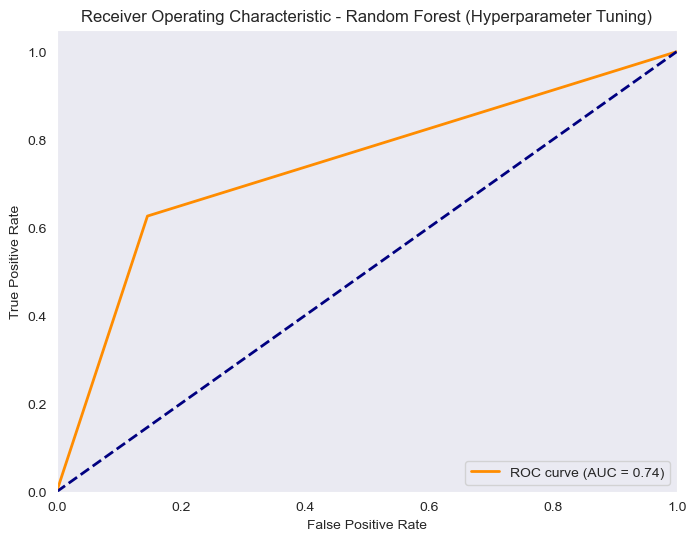

In [248]:
# plot roc curve
y_pred_prob = rf_random_search.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='Random Forest (Hyperparameter Tuning)')

### AdaBoost

#### Feature Importances

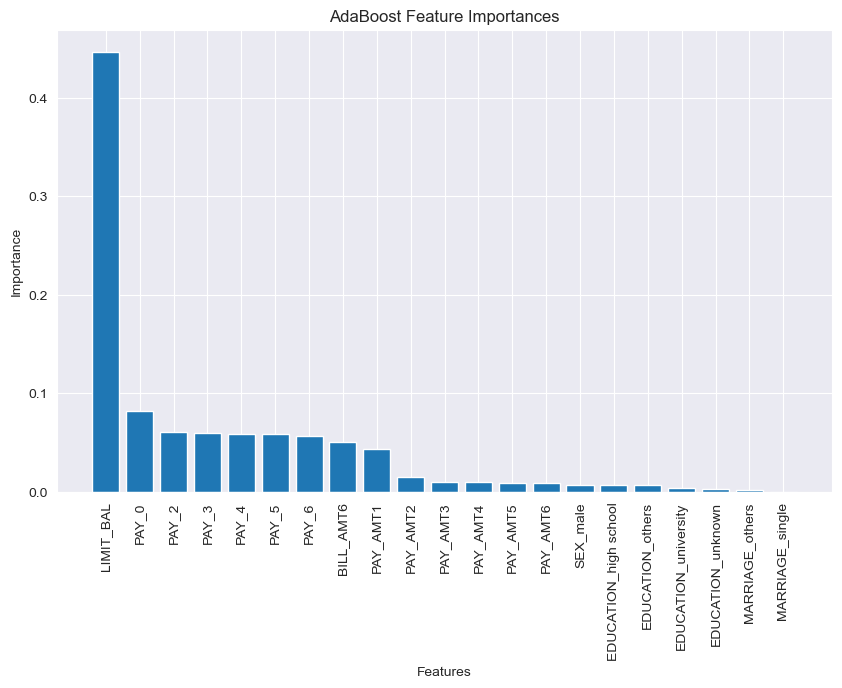

In [249]:
# plot the feature importances
feature_importances = ada_model.feature_importances_

# Sort the feature importances
sorted_indices = feature_importances.argsort()[::-1]
feature_importances = feature_importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importances)
plt.title('AdaBoost Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

#### Accuracy

In [250]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_ada)
print("Accuracy:", accuracy)

Accuracy: 0.7302740863787376


#### Confusion Matrix

In [251]:
conf_matrix = confusion_matrix(y_test, y_pred_ada)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[2867  704]
 [ 595  650]]


#### Classification Report

In [252]:
# use classification report
class_report = classification_report(y_test, y_pred_ada)
print(class_report)

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      3571
           1       0.48      0.52      0.50      1245

    accuracy                           0.73      4816
   macro avg       0.65      0.66      0.66      4816
weighted avg       0.74      0.73      0.73      4816



#### ROC Curve

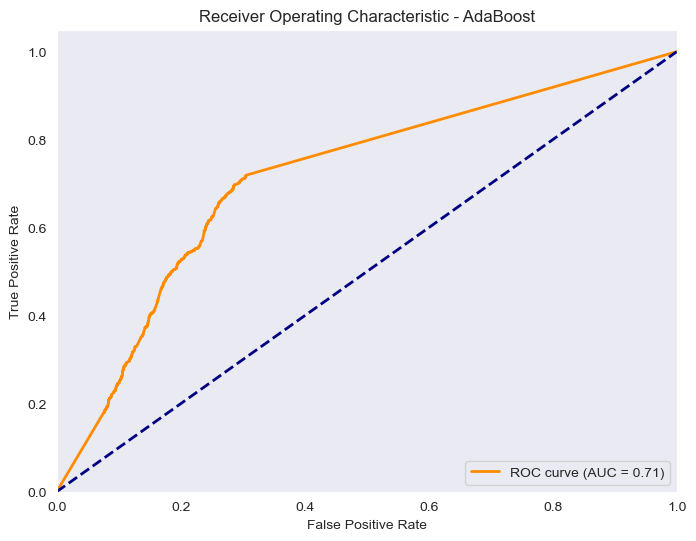

In [253]:
# plot roc curve
y_pred_prob = ada_model.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='AdaBoost')

#### with Hyperparameter Tuning

##### Accuracy

In [254]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_ada_hyper)
print("Accuracy:", accuracy)

Accuracy: 0.8087624584717608


##### Confusion Matrix

In [255]:
conf_matrix = confusion_matrix(y_test, y_pred_ada_hyper)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3191  380]
 [ 541  704]]


##### Classification Report

In [256]:
# use classification report
class_report = classification_report(y_test, y_pred_ada_hyper)
print(class_report)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3571
           1       0.65      0.57      0.60      1245

    accuracy                           0.81      4816
   macro avg       0.75      0.73      0.74      4816
weighted avg       0.80      0.81      0.80      4816



##### ROC Curve

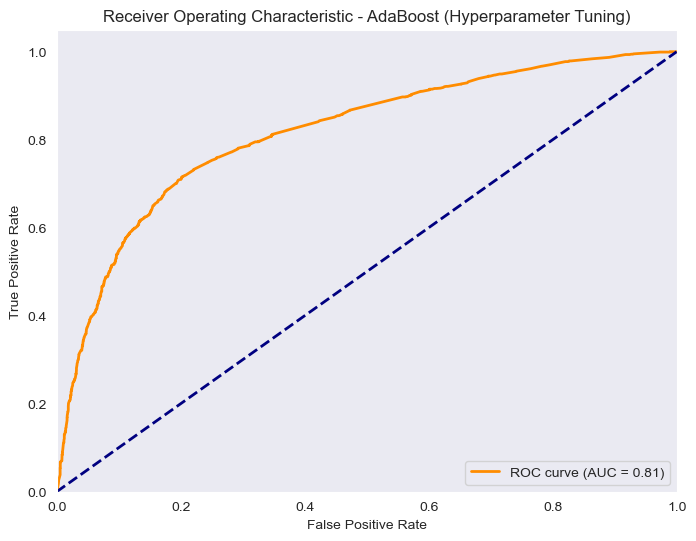

In [257]:
# plot roc curve
y_pred_prob = ada_grid_search.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='AdaBoost (Hyperparameter Tuning)')

### XGBoost

#### Feature Importances

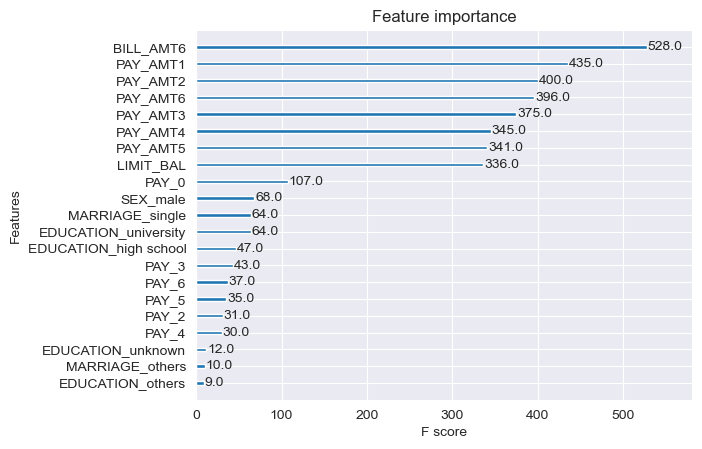

In [258]:
# plot the feature importances
xgb.plot_importance(xgb_model)
plt.show()

#### Accuracy

In [259]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)

Accuracy: 0.7979651162790697


#### Confusion Matrix

In [260]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3219  352]
 [ 621  624]]


#### Classification Report

In [261]:
# use classification report
class_report = classification_report(y_test, y_pred_xgb)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3571
           1       0.64      0.50      0.56      1245

    accuracy                           0.80      4816
   macro avg       0.74      0.70      0.72      4816
weighted avg       0.79      0.80      0.79      4816



#### ROC Curve

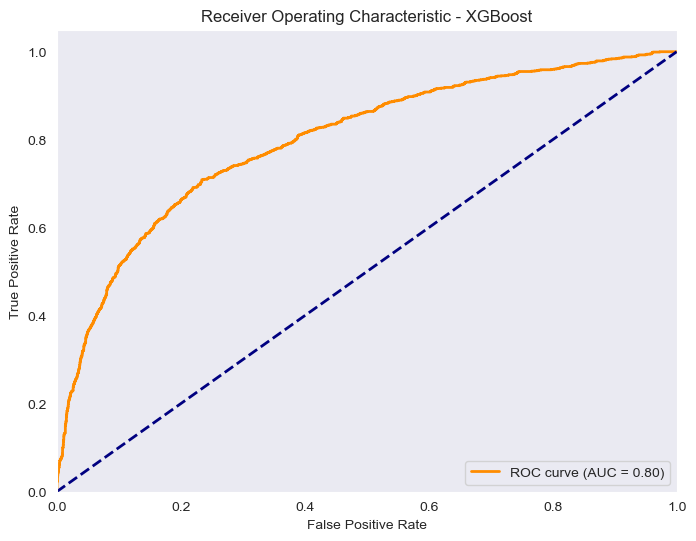

In [262]:
# plot roc curve
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='XGBoost')

#### with Hyperparameter Tuning

##### Accuracy

In [263]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb_hyper)
print("Accuracy:", accuracy)

Accuracy: 0.7977574750830565


##### Confusion Matrix

In [264]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb_hyper)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[3043  528]
 [ 446  799]]


##### Classification Report

In [265]:
# use classification report
class_report = classification_report(y_test, y_pred_xgb_hyper)
print(class_report)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3571
           1       0.60      0.64      0.62      1245

    accuracy                           0.80      4816
   macro avg       0.74      0.75      0.74      4816
weighted avg       0.80      0.80      0.80      4816



##### ROC Curve

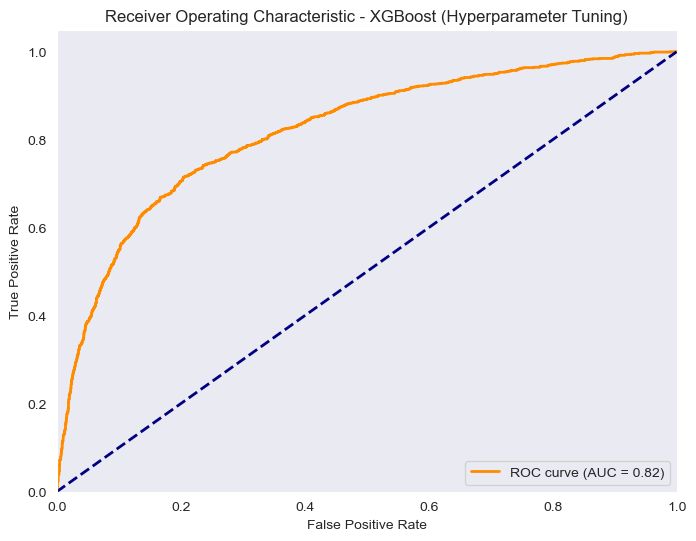

In [266]:
# plot roc curve
y_pred_prob = xgb_random_search.predict_proba(X_test)[:, 1]
utils.plot_roc_curve(y_test, y_pred_prob, model_name='XGBoost (Hyperparameter Tuning)')

## Combined Model Scores

In [282]:
# Create a DataFrame with the model statistics with and without hyperparameter tuning
models = ['Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost']
predictions_base = [y_pred_logit, y_pred_rf, y_pred_ada, y_pred_xgb]
predictions_hyper = [y_pred_lr_hyper, y_pred_rf_hyper, y_pred_ada_hyper, y_pred_xgb_hyper]

results = utils.evaluate_models(models=models, predictions_base=predictions_base, predictions_hyper=predictions_hyper,
                                y_test=y_test)
results

,,Logistic Regression,Random Forest,AdaBoost,XGBoost,Best Model,Highest Value
Metric,Type,,,,,,
Accuracy,Base,0.810008,0.803779,0.730274,0.797965,Logistic Regression,0.810839
Precision,Base,0.686652,0.650301,0.480059,0.639344,Logistic Regression,0.686801
Recall,Base,0.48755,0.521285,0.522088,0.501205,XGBoost,0.641767
F1 Score,Base,0.570221,0.578689,0.500192,0.561909,XGBoost,0.621306
Positive Precision,Base,0.686652,0.650301,0.480059,0.639344,Logistic Regression,0.686801
Negative Precision,Base,0.837742,0.843897,0.828134,0.838281,XGBoost,0.872170
Positive Recall,Base,0.48755,0.521285,0.522088,0.501205,XGBoost,0.641767
Negative Recall,Base,0.922431,0.902268,0.802856,0.901428,Logistic Regression,0.922431
Positive F1 Score,Base,0.570221,0.578689,0.500192,0.561909,XGBoost,0.621306


precision of non defaulters matters a lot more for a bank